# Neural Style
## Content
### 1. Brief explanation
### 2. Loading Image
### 3. Loss functions
### 4. importing Model
### 5. Run

* * *
#### 1. Brief explanation
- Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style. 
- 1. The algorithm takes three images, 
    > an input image  
    a content-image  
    a style-image  
    
- 2. changes the input to resemble the content of the content-image and the artistic style of the style-image.
     >1. The principle is simple: we define two distances
        - one for the content (DC)
        - DC measures how different the content is between two images. (input vs content)
        - one for the style (DS)
        - DS measures how different the style is between two images.  (input vs style)
        
     >2. we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. 

**Note**
- The application can be slightly different according to input image
- Case 1: random noise input image
    - In this case, random noise image changes into style image based content image.
- Case 2: Content image as input image
    - In this case, the style of it changes into the style of style image.

In [1]:
from __future__ import print_function

import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* * *
#### 2. Loading the images
- Now we will import the style and content images.
- The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1.
- The images also need to be resized to have the same dimensions. 

- An important detail to note is that __neural networks from the torch library are trained with tensor values ranging from 0 to 1__.
- If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style. 
- However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

In [3]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
        transforms.Resize(size=(imsize, imsize)),
        transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./Data/picasso.jpg")
content_img = image_loader("./Data/dancing.jpg")

assert style_img.size() == content_img.size(), \
"we need to import style and content images of the same size"

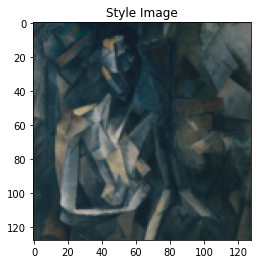

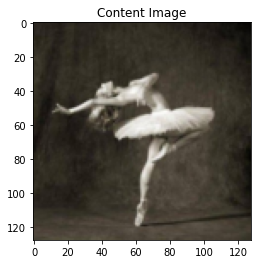

In [4]:
unloader = transforms.ToPILImage()   # reconvert into PIL image
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

* * *
#### 3. Loss Functions

- There are two types of Losses: Content Loss and Style Loss

>3-1. Content Loss
- The content loss is a function that represents a weighted version of the content distance for an individual layer. 
- The function takes the feature maps F_XL of a layer L in a network processing input X 
    - returns the weighted content distance $Weight * Content Loss(X,C)$ between the image X and the content image C.
- The feature maps of the content image(FCL) must be known by the function in order to calculate the content distance.

>3-2. Style Loss
- It will act as a transparent layer in a network that computes the style loss of that layer.  
- In order to calculate the style loss, we need to compute the gram matrix G_XL.  
- A gram matrix is the result of multiplying a given matrix by its transposed matrix.  
- In this application, the given matrix is a reshaped version of the feature maps F_XL of a layer L.

- Finally, the gram matrix **must be normalized by dividing each element by the total number of elements in the matrix.  
- This normalization is to counteract the fact that F^XL matrices with a large N dimension yield larger values in the Gram matrix.   
- These larger values will cause the first layers (before pooling layers) to have a larger impact during the gradient descent.  
- Style features tend to be in the deeper layers of the network so this normalization step is crucial.  


#### Abount Gram
- Gram Matrix
- Style representation of an image relies on looking at **correlations between features of individual layers.
- Typically, similarities can be found between multiple layers. 
    - By considering correlations between multiple layers of different sizes, multi style representation of image can be obtained. 
    - Style representation is captured from output of first convolution layer in all 5-layer stacks (conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1). The correlation at each layer are given by Gram Matrix.


- G = V.V-Transpose
- To calculate gram matrix, *the feature maps at each layer is to be flattened* and formed one matrix. 
- This matrix multiplied by its transpose gives a gram matrix.  
- Suppose if a layer has 8 feature maps each with L*W of 4*4, then matrix of 8*16 is formed.   
- This is multiplied with its transpose to get gram matrix of 8*8. This is more of co-variance matrix between each feature.
- Now we have gram matrix representing the style information in a layer. 
- We can calculate the style loss now.

![nn](Img/3.png)
![nn](Img/4.png)

#### How does Gram matrix encode the Style of an image?

- Assume that Filter 1 captures horizontal, Filter 2 do vertical line in a given image.
- Calculating dot product with filter 1s in features and transpose of it makes activated neural more activated.
- The reason is that trained filters activate particular area where they see the specific pattern or texture, the area gets more enforced with matrix multiplication calculating the gram matrix.

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # target == cnn(content img)
    
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return (input)

![nn](Img/1.png)

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size() # a = batch size (=1)
                              # b = number of feature maps
                              # (c,d) = dimensions of a feature map (N=c*d)
    features = input.view(a * b, c * d) # resize F_xl into \hat F_xl
    
    
    G = torch.mm(features, features.t())  # the gram product
    
    # normalize the gram matrix
    # by dividing by the number of element in each feature maps
    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

![nn](Img/2.png)

- That is, content loss와 style loss를 만들어 삽입하여 forward 할 때 마다 계산을 하고 backward시 편하게 input image의 Gradient를 구할 수 있게 된다.
* input image에 requires grad를 True로 설정하면 쉽다.

#### 4. Importing the Model

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

#### NOTE
- vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth.   
- We need to add our content loss and style loss layers immediately after the convolution layer they are detecting.  
- To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [10]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img,
                              content_layers = content_layers_default,
                              style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):   # cnn Convolution만 불러오기
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            
            content_loss = ContentLoss(target)   # create object            
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i +1)]
    return model, style_losses, content_losses

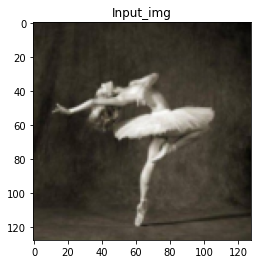

In [11]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input_img')

#### Gradient Descent
- Unlike training a network, we want to train the input image in order to minimise the content/style losses. 
- We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [12]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

- Finally, we must define a function that performs the neural transfer.  
- For each iteration of the networks, it is fed an updated input and computes new losses.  
- We will run the backward methods of each loss module to dynamicaly compute their gradients.  
- The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    
    print('모델', model)
    
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

#### 5. Run

Building the style transfer model..


C:\Users\anjae\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\anjae\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


모델 Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
Optimizing..
run [50]:
Style Loss : 4.463728 Content Loss: 10.876625

run [100]:
Style Loss : 1.979038 Content Loss: 6.831600

run [

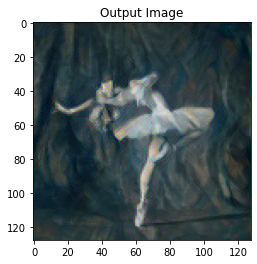

In [14]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=100000,
                           num_steps=300)


plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

#### REFERENCE

- Overall content: Pytorch neural style tutorial  
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#neural-transfer-using-pytorch


- Gram matrix  
https://www.amitagrawal.org/blog/2017/12/1/how-does-gram-matrix-encode-the-style-of-an-image